In [1]:
import torch
import open_clip
import itertools
from PIL import Image

import lxt.functional as lf
from lxt.models.openclip import attnlrp
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules
from zennit.image import imgify


device = 'cuda'

# Load the model and the tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
model.eval()
model = model.to(device)


c:\Users\Stern\clip_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Stern\clip_env\lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

In [2]:

tokenizer = open_clip.get_tokenizer('ViT-g-14')


In [4]:
# Load an image and tokenize a text
text = tokenizer(['a beautiful LRP heatmap', 'a dog', 'a cat']).to(device)
image = preprocess(Image.open('dog_and_cat.jpg')).unsqueeze(0).to(device)



In [5]:
# trace the model with a dummy input
# verbose=True prints all functions/layers found and replaced by LXT
# you will see at the last entry that e.g. tensor.exp() is not supported by LXT. This is not a problem in our case,
# because this function is not used in the backward pass and therefore does not need to be replaced.
# (look into the open_clip.transformer module code!)
x = torch.randn(1, 3, 224, 224, device=device)
traced = attnlrp.register(model, dummy_inputs={'image': x, 'text': text}, verbose=True)



+-------------------------------------------------------------------------------------------------+---------------------------------------------------------------+------------+------------------+
| Parent Module                                                                                   | Function                                                      | Replaced   | LRP compatible   |
+=================================================================================================+===============================================================+============+==================+
| ('visual.conv1', <class 'torch.nn.modules.conv.Conv2d'>)                                        | -                                                             | -          |  ⁇               |
+-------------------------------------------------------------------------------------------------+---------------------------------------------------------------+------------+------------------+
| ('visual.patch_dro

In [6]:
# for Vision Transformer, we must perform a grid search for the best gamma hyperparameters
# in general, it is enough to concentrate on the Conv2d and MLP layers
# for simplicity we just use a few values that can be evaluated by hand & looking at the heatmaps
heatmaps = []
for conv_gamma, lin_gamma in itertools.product([0.1, 0.5, 100], [0, 0.01, 0.05, 0.1, 1]):

    print("Gamma Conv2d:", conv_gamma, "Gamma Linear:", lin_gamma)

    # we define rules for the Conv2d and Linear layers using 'Zennit'
    zennit_comp = LayerMapComposite([
            (torch.nn.Conv2d, z_rules.Gamma(conv_gamma)),
            (torch.nn.Linear, z_rules.Gamma(lin_gamma)),
        ])

    # register composite
    zennit_comp.register(traced)

    # forward & backward pass
    y = traced(image.requires_grad_(True), text)
    logits = lf.matmul(y[0], y[1].transpose(0, 1))

    # explain the dog class ("a dog")
    image.grad = None
    logits[0, 1].backward()

    # normalize the heatmap
    heatmap = image.grad[0].sum(0)
    heatmap = heatmap / abs(heatmap).max()
    heatmaps.append(heatmap.cpu().numpy())

    # zennit composites can be removed so that we can register a new one!
    zennit_comp.remove()

# save the heatmaps as a grid
imgify(heatmaps, vmin=-1, vmax=1, grid=(3, 5)).save('heatmap.png')

Gamma Conv2d: 0.1 Gamma Linear: 0
Gamma Conv2d: 0.1 Gamma Linear: 0.01
Gamma Conv2d: 0.1 Gamma Linear: 0.05
Gamma Conv2d: 0.1 Gamma Linear: 0.1
Gamma Conv2d: 0.1 Gamma Linear: 1
Gamma Conv2d: 0.5 Gamma Linear: 0
Gamma Conv2d: 0.5 Gamma Linear: 0.01
Gamma Conv2d: 0.5 Gamma Linear: 0.05
Gamma Conv2d: 0.5 Gamma Linear: 0.1
Gamma Conv2d: 0.5 Gamma Linear: 1
Gamma Conv2d: 100 Gamma Linear: 0
Gamma Conv2d: 100 Gamma Linear: 0.01
Gamma Conv2d: 100 Gamma Linear: 0.05
Gamma Conv2d: 100 Gamma Linear: 0.1
Gamma Conv2d: 100 Gamma Linear: 1


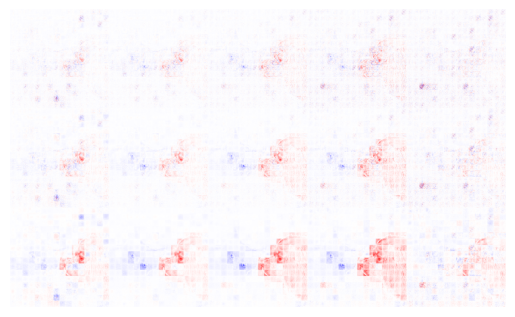

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the saved image
img = Image.open('heatmap.png')  # Ensure 'heatmap.png' is in the correct directory
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()
